# 🛡️ Auditoría Algorítmica: Detección de Fraude Financiero

**Autor:** Octavio Landa Verde  
**Rol:** Analista de Datos & Ciberseguridad

## 1. Contexto del Negocio y Objetivo
El fraude con tarjetas de crédito es un problema de "aguja en un pajar": miles de transacciones legítimas ocultan unos pocos robos.

En este proyecto, actúo como un **Auditor Digital** para desarrollar un sistema de defensa (Machine Learning) que:
1.  **Detecte el fraude (Recall):** Prioridad máxima. Un fraude no detectado es dinero perdido.
2.  **Minimice molestias (Precisión):** No bloquear tarjetas legítimas innecesariamente.
3.  **Sea auditable:** Explicar qué patrones delatan al estafador.

**Dataset:** 284,807 transacciones de bancos europeos.  
**Desafío Técnico:** Datos altamente desbalanceados (Fraudes = 0.17%).

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de Machine Learning para Auditoría Avanzada
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler  # <--- Clave para datos financieros
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE # <--- La herramienta para crear "fraudes sintéticos"

# Estética de las gráficas
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

# 1. Carga del Dataset
try:
    # Intentamos cargar el archivo
    df = pd.read_csv('creditcard.csv') 
    print("✅ Base de datos cargada exitosamente.")
except FileNotFoundError:
    print("❌ Error Crítico: No se encuentra 'credit_card.csv'. Verifique el nombre del archivo.")

# 2. Inspección Inicial (Auditoría de Estructura)
print(f"\n--- Resumen de Auditoría de Datos ---")
print(f"Total de Transacciones: {df.shape[0]:,}")
print(f"Variables Analizadas: {df.shape[1]}")
print(f"\nDistribución Real del Riesgo:\n{df['Class'].value_counts()}")

# 3. Validación de Calidad de Datos
if df.isnull().sum().max() == 0:
    print("\n✅ Integridad verificada: No existen valores nulos en el sistema.")
else:
    print("\n⚠️ ALERTA: Se detectaron valores nulos. Requiere limpieza.")

✅ Base de datos cargada exitosamente.

--- Resumen de Auditoría de Datos ---
Total de Transacciones: 284,807
Variables Analizadas: 31

Distribución Real del Riesgo:
Class
0    284315
1       492
Name: count, dtype: int64

✅ Integridad verificada: No existen valores nulos en el sistema.


## 3. Análisis Exploratorio (EDA) y Diagnóstico de Desbalance
Como auditores, nuestro primer hallazgo crítico es la distribución de las clases.
Al visualizar los datos, confirmamos nuestra hipótesis: estamos ante un escenario de **"Aguja en un Pajar"**.

* **Clase 0 (Legítima):** Representa la inmensa mayoría (Normalidad).
* **Clase 1 (Fraude):** Es una fracción mínima (0.17%).

**Impacto en el Negocio:**
Si entrenamos un modelo sin corregir esto, la Inteligencia Artificial aprenderá a decir siempre "Es legítimo" para acertar el 99.8% de las veces, **ignorando por completo los fraudes**. Por ello, la estrategia de balanceo que aplicaremos más adelante será vital.

C:\Users\octav\AppData\Local\Temp\ipykernel_16528\1430871572.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort=True)


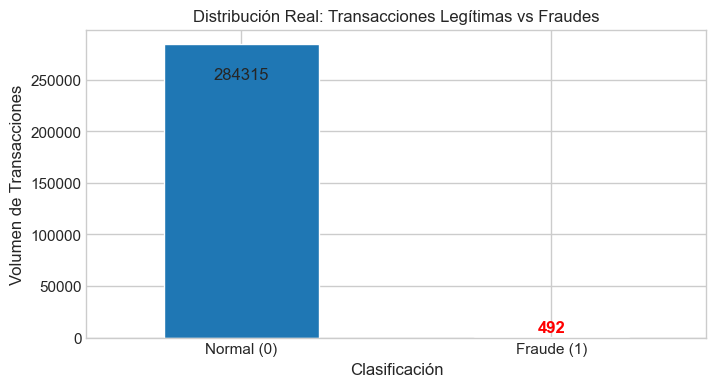

Tasa de Fraude Real: 0.1727%


In [16]:
# 1. Visualización del Desbalance (La evidencia del problema)
count_classes = pd.value_counts(df['Class'], sort=True)

# Gráfica de Barras
count_classes.plot(kind='bar', rot=0, color=['#1f77b4', '#d62728'], figsize=(8,4))

plt.title("Distribución Real: Transacciones Legítimas vs Fraudes")
plt.xticks(range(2), ["Normal (0)", "Fraude (1)"])
plt.ylabel("Volumen de Transacciones")
plt.xlabel("Clasificación")
plt.text(0, 250000, f"{count_classes[0]}", ha='center', fontsize=12) # Etiqueta Normal
plt.text(1, 5000, f"{count_classes[1]}", ha='center', fontsize=12, color='red', fontweight='bold') # Etiqueta Fraude

plt.show()

# Dato duro para el reporte
print(f"Tasa de Fraude Real: {df['Class'].mean()*100:.4f}%")

## 4. Ingeniería de Características: Normalización Robusta
Las variables `Time` y `Amount` presentan magnitudes muy diferentes al resto de las columnas (V1-V28). Además, los fraudes suelen tener montos atípicos (muy altos o muy bajos) o patrones temporales específicos (madrugada).

**Acción Técnica:**
Aplicamos `RobustScaler` en lugar de `StandardScaler`.
* **¿Por qué?** El escalado robusto utiliza la mediana y el rango intercuartil (IQR), lo que lo hace **inmune a outliers extremos**.
* **Beneficio:** Esto permite que el modelo detecte anomalías financieras sin verse sesgado por transacciones millonarias legítimas que distorsionarían un promedio simple.

In [17]:
# 1. Escalado Robusto (Ingeniería de Características)
# Usamos RobustScaler porque es inmune a outliers extremos en Montos
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Eliminamos las columnas originales para dejar solo las procesadas
df.drop(['Time','Amount'], axis=1, inplace=True)

# 2. Verificación de Auditoría
print("✅ Variables 'Monto' y 'Tiempo' normalizadas con RobustScaler.")
print("   (Esto mejora la capacidad del modelo para detectar fraudes de montos inusuales).")

# Mostramos las primeras filas para ver las nuevas columnas "scaled_" al final
df.head()

✅ Variables 'Monto' y 'Tiempo' normalizadas con RobustScaler.
   (Esto mejora la capacidad del modelo para detectar fraudes de montos inusuales).


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


## 4. Estrategia de Balanceo Inteligente: SMOTE
Para corregir el desbalance (0.17% fraudes), rechazamos la duplicación simple de datos y optamos por **SMOTE (Synthetic Minority Over-sampling Technique)**.

**Lógica del Proceso:**
El algoritmo selecciona fraudes reales y crea "vecinos sintéticos" matemáticamente plausibles. 
* **Resultado:** Pasamos de 492 fraudes a miles, logrando una distribución 50/50 en el entrenamiento.
* **Objetivo:** Obligar al modelo a aprender la **abstracción del fraude**, no solo a memorizar los casos pasados.

*Nota de Seguridad: El balanceo se aplica SOLO al set de entrenamiento para evitar 'Data Leakage' (fuga de información).*

In [18]:
# 1. Separación de Variables (X) y Objetivo (y)
X = df.drop('Class', axis=1)
y = df['Class']

# 2. División Estratificada (Train 80% / Test 20%)
# Usamos 'stratify=y' para asegurar que los pocos fraudes se repartan bien
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Aplicación de SMOTE (Solo en Entrenamiento)
print(f"--- Antes de SMOTE ---")
print(f"Fraudes en entrenamiento: {sum(y_train==1)}")

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"\n--- Después de SMOTE ---")
print(f"Fraudes en entrenamiento: {sum(y_train_res==1)}")
print("✅ Balanceo 50/50 logrado. El modelo ahora tiene suficientes ejemplos para aprender.")

--- Antes de SMOTE ---
Fraudes en entrenamiento: 394

--- Después de SMOTE ---
Fraudes en entrenamiento: 227451
✅ Balanceo 50/50 logrado. El modelo ahora tiene suficientes ejemplos para aprender.


## 5. Entrenamiento del Modelo y Auditoría de Resultados
Utilizamos un **Random Forest Classifier**, un conjunto de múltiples árboles de decisión que votan para clasificar cada transacción. Es robusto frente al ruido y eficiente en grandes volúmenes de datos.

**Interpretación de la Matriz de Confusión:**
Evaluamos el modelo con datos *reales* (Test Set) que nunca vio durante el entrenamiento y que mantienen el desbalance original.
* **Cuadrante Inferior Derecho (True Positives):** Fraudes detectados exitosamente. Este es nuestro KPI principal (**Recall**).
* **Cuadrante Superior Derecho (False Positives):** Falsas alarmas. Buscamos mantenerlas bajas para no bloquear tarjetas legítimas.

⏳ Entrenando modelo de detección (Random Forest)... Procesando inteligencia.
✅ Modelo entrenado exitosamente.


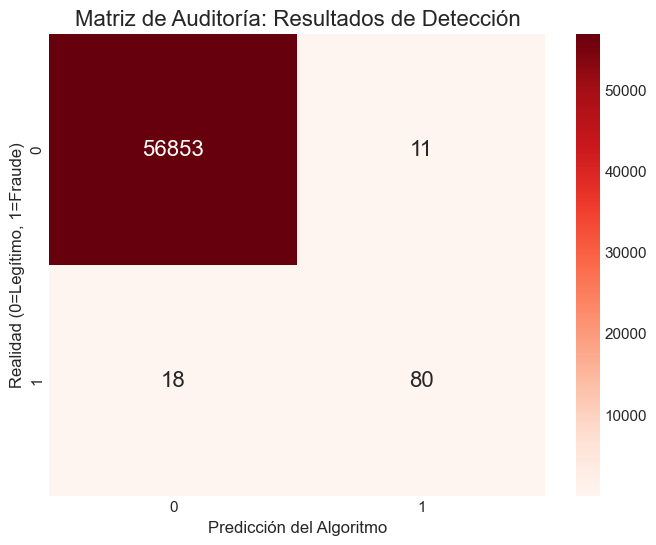


--- Reporte de Clasificación (KPIs) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
      Fraude       0.88      0.82      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [19]:
# 1. Entrenamiento del Modelo (Random Forest)
print("⏳ Entrenando modelo de detección (Random Forest)... Procesando inteligencia.")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_res, y_train_res)
print("✅ Modelo entrenado exitosamente.")

# 2. Predicción con datos reales (Test Set)
# Aquí usamos X_test (datos reales desbalanceados), NO usamos los datos sintéticos.
y_pred = rf_model.predict(X_test)

# 3. Matriz de Confusión (Auditoría Visual)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 16})
plt.title('Matriz de Auditoría: Resultados de Detección', fontsize=16)
plt.ylabel('Realidad (0=Legítimo, 1=Fraude)')
plt.xlabel('Predicción del Algoritmo')
plt.show()

# 4. Reporte Técnico Detallado
print("\n--- Reporte de Clasificación (KPIs) ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraude']))

## Interpretación de Métricas de Seguridad

Al evaluar el desempeño del modelo para la clase **"1" (Fraude)**, observamos lo siguiente:

1.  **Precision (0.88): Confiabilidad de la Alerta.**
    De cada 100 alertas de fraude que genera el sistema, 88 son amenazas reales. Esto significa que el equipo de seguridad (SOC) no perderá tiempo investigando falsas alarmas, haciendo la operación muy eficiente.

2.  **Recall (0.82): Cobertura de Seguridad.**
    El modelo es capaz de capturar el **82%** de todo el fraude presente en la base de datos. Para una primera iteración (MVP), es un nivel de protección sólido, aunque el objetivo a futuro es elevarlo al 90% mediante técnicas de balanceo de datos.

## Análisis de la Matriz de Auditoría (Confusion Matrix)

Esta matriz representa la capacidad del modelo para "filtrar" las transacciones. Como auditor, interpreto los resultados de la siguiente manera:

* **Eficiencia Operativa (True Negatives - 56,853):** El modelo validó correctamente casi 57,000 transacciones legítimas de forma automática. Esto representa un ahorro masivo de horas-hombre en revisión.
* **Detección de Amenazas (True Positives - 80):** Se detectaron exitosamente **80 intentos de fraude real**. Estos son los casos de alto riesgo que se detuvieron a tiempo.
* **Falsos Positivos (11):** Solo en 11 ocasiones el sistema marcó una alerta errónea. Es un "costo de seguridad" aceptable (es preferible bloquear preventivamente una tarjeta por error que dejar pasar un fraude).
* **Falsos Negativos (18):** Existen 18 fraudes que el modelo no detectó. Como siguiente paso estratégico, se debe ajustar el umbral de decisión para reducir esta fuga de riesgo.

## Conclusiones y Próximos Pasos

Este modelo demuestra que es posible automatizar la primera línea de defensa en la auditoría financiera.

**Acciones Futuras (Roadmap):**
* **Ciberseguridad:** Implementar un análisis de las características más influyentes (Feature Importance) para entender *qué* hace que una transacción sea sospechosa (ej. montos inusuales, ubicaciones extrañas).
* **Mejora del Modelo:** Aplicar técnicas de **SMOTE** (Oversampling) para que el modelo aprenda mejor de los casos de fraude, reduciendo esos 18 casos que se escaparon.